In [1]:
# ==========================================
# Student Performance & Dropout Prediction
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
# ==========================================
# 1. Load Dataset
# ==========================================

df = pd.read_csv(r"C:\Users\shash\Desktop\General_Folder\Student Performance Prediction System\Data\student-mat.csv", sep=';')
df = pd.get_dummies(df, drop_first=True)

print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (395, 42)
   age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         3       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  ...  guardian_mother  guardian_other  schoolsup_yes  famsup_yes  \
0     1  ...             True           False           True       False   
1     1  ...            False           False          False        True   
2     2  ...             True           False           True       False   
3     1  ...             True           False          False        True   
4     1  ...            False           False          False        True   

   paid_yes  activities_yes  nursery_

In [3]:
# ==========================================
# 2. Encode Categorical Columns
# ==========================================

le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [4]:
# ==========================================
# 3. Feature Engineering
# ==========================================

# Dropout Risk (Fail if final grade < 10)
df['dropout_risk'] = df['G3'].apply(lambda x: 1 if x < 10 else 0)

# Academic progress feature
df['grade_improvement'] = df['G2'] - df['G1']

# Attendance impact feature
df['attendance_score'] = df['studytime'] / (df['absences'] + 1)

In [5]:
# ==========================================
# 4. Define Features & Targets
# ==========================================

# ----- Grade Prediction (Regression) -----
X_grade = df.drop(['G3', 'dropout_risk'], axis=1)
y_grade = df['G3']

# ----- Dropout Prediction (Classification) -----
X_drop = df.drop(['G3', 'dropout_risk'], axis=1)
y_drop = df['dropout_risk']

In [6]:
# ==========================================
# 5. Train Test Split
# ==========================================

Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_grade, y_grade, test_size=0.2, random_state=42
)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    X_drop, y_drop, test_size=0.2, random_state=42, stratify=y_drop
)

In [7]:
# ==========================================
# 6. Feature Scaling
# ==========================================

scaler_grade = StandardScaler()
scaler_drop = StandardScaler()

Xg_train = scaler_grade.fit_transform(Xg_train)
Xg_test = scaler_grade.transform(Xg_test)

Xd_train = scaler_drop.fit_transform(Xd_train)
Xd_test = scaler_drop.transform(Xd_test)

In [8]:
# ==========================================
# 7. Train Models
# ==========================================

# ----- Grade Regression Model -----
grade_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42
)

grade_model.fit(Xg_train, yg_train)


# ----- Dropout Classification Model -----
drop_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42
)

drop_model.fit(Xd_train, yd_train)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=42)

In [9]:
# ===============================
# CROSS VALIDATION
# ===============================

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    drop_model,
    Xd_train,
    yd_train,
    cv=5,
    scoring='accuracy'
)

print("\nCross Validation Scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())


Cross Validation Scores: [0.90625    0.87301587 0.93650794 0.95238095 0.92063492]
Average CV Accuracy: 0.9177579365079366


In [10]:
# ===============================
# MODEL COMPARISON
# ===============================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier()
}

print("\nModel Comparison Results:")

for name, model in models.items():
    model.fit(Xd_train, yd_train)
    pred = model.predict(Xd_test)
    print(name, "Accuracy:", accuracy_score(yd_test, pred))


Model Comparison Results:
Random Forest Accuracy: 0.9113924050632911
Logistic Regression Accuracy: 0.9240506329113924
Gradient Boosting Accuracy: 0.9240506329113924


In [11]:
# ==========================================
# 8. Evaluate Models
# ==========================================

# ----- Grade Prediction -----
grade_preds = grade_model.predict(Xg_test)

rmse = np.sqrt(mean_squared_error(yg_test, grade_preds))
r2 = r2_score(yg_test, grade_preds)

print("\n===== Grade Prediction Results =====")
print("RMSE:", rmse)
print("R2 Score:", r2)


# ----- Dropout Prediction -----
drop_preds = drop_model.predict(Xd_test)

acc = accuracy_score(yd_test, drop_preds)

print("\n===== Dropout Prediction Results =====")
print("Accuracy:", acc)


===== Grade Prediction Results =====
RMSE: 1.9107964039446244
R2 Score: 0.8219393084251069

===== Dropout Prediction Results =====
Accuracy: 0.9240506329113924


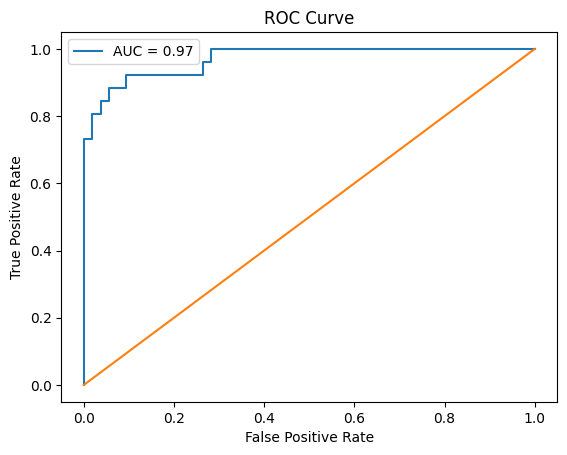

In [12]:
# ===============================
# ROC CURVE + AUC
# ===============================

from sklearn.metrics import roc_curve, auc

probs = drop_model.predict_proba(Xd_test)[:,1]

fpr, tpr, _ = roc_curve(yd_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



GRADE PREDICTION EVALUATION
MAE : 1.1714767932489452
MSE : 3.651142897327708
RMSE: 1.9107964039446244
R2 Score: 0.8219393084251069

DROPOUT PREDICTION EVALUATION
Accuracy : 0.9240506329113924
Precision: 0.8846153846153846
Recall   : 0.8846153846153846
F1 Score : 0.8846153846153846

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        53
           1       0.88      0.88      0.88        26

    accuracy                           0.92        79
   macro avg       0.91      0.91      0.91        79
weighted avg       0.92      0.92      0.92        79



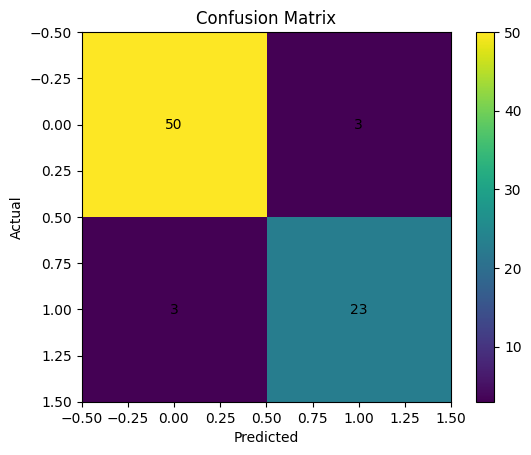

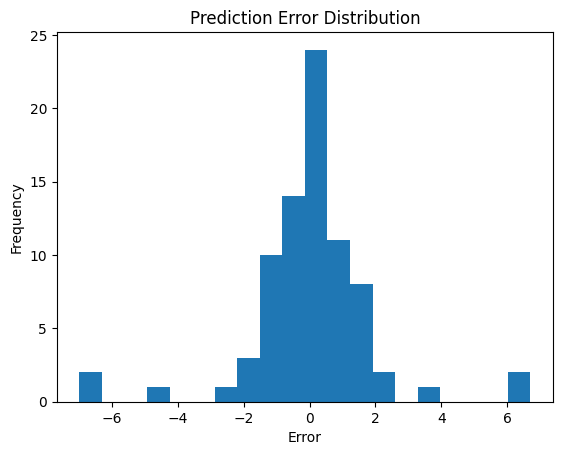

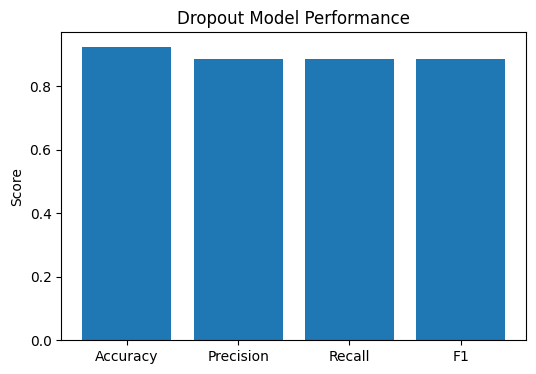

In [13]:
# ==========================================
# COMPLETE MODEL EVALUATION BLOCK
# ==========================================

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# -------------------------------
# Grade Prediction Evaluation
# -------------------------------
print("\n==============================")
print("GRADE PREDICTION EVALUATION")
print("==============================")

mae = mean_absolute_error(yg_test, grade_preds)
mse = mean_squared_error(yg_test, grade_preds)
rmse = np.sqrt(mse)
r2 = r2_score(yg_test, grade_preds)

print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


# -------------------------------
# Dropout Prediction Evaluation
# -------------------------------
print("\n==============================")
print("DROPOUT PREDICTION EVALUATION")
print("==============================")

acc = accuracy_score(yd_test, drop_preds)
prec = precision_score(yd_test, drop_preds)
rec = recall_score(yd_test, drop_preds)
f1 = f1_score(yd_test, drop_preds)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

print("\nClassification Report:\n")
print(classification_report(yd_test, drop_preds))


# -------------------------------
# Confusion Matrix Visualization
# -------------------------------
cm = confusion_matrix(yd_test, drop_preds)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()


# -------------------------------
# Grade Prediction Error Plot
# -------------------------------
errors = yg_test - grade_preds

plt.figure()
plt.hist(errors, bins=20)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


# -------------------------------
# Dropout Metrics Bar Chart
# -------------------------------
plt.figure(figsize=(6,4))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1']
metrics_values = [acc, prec, rec, f1]

plt.bar(metrics_names, metrics_values)
plt.title("Dropout Model Performance")
plt.ylabel("Score")

plt.show()

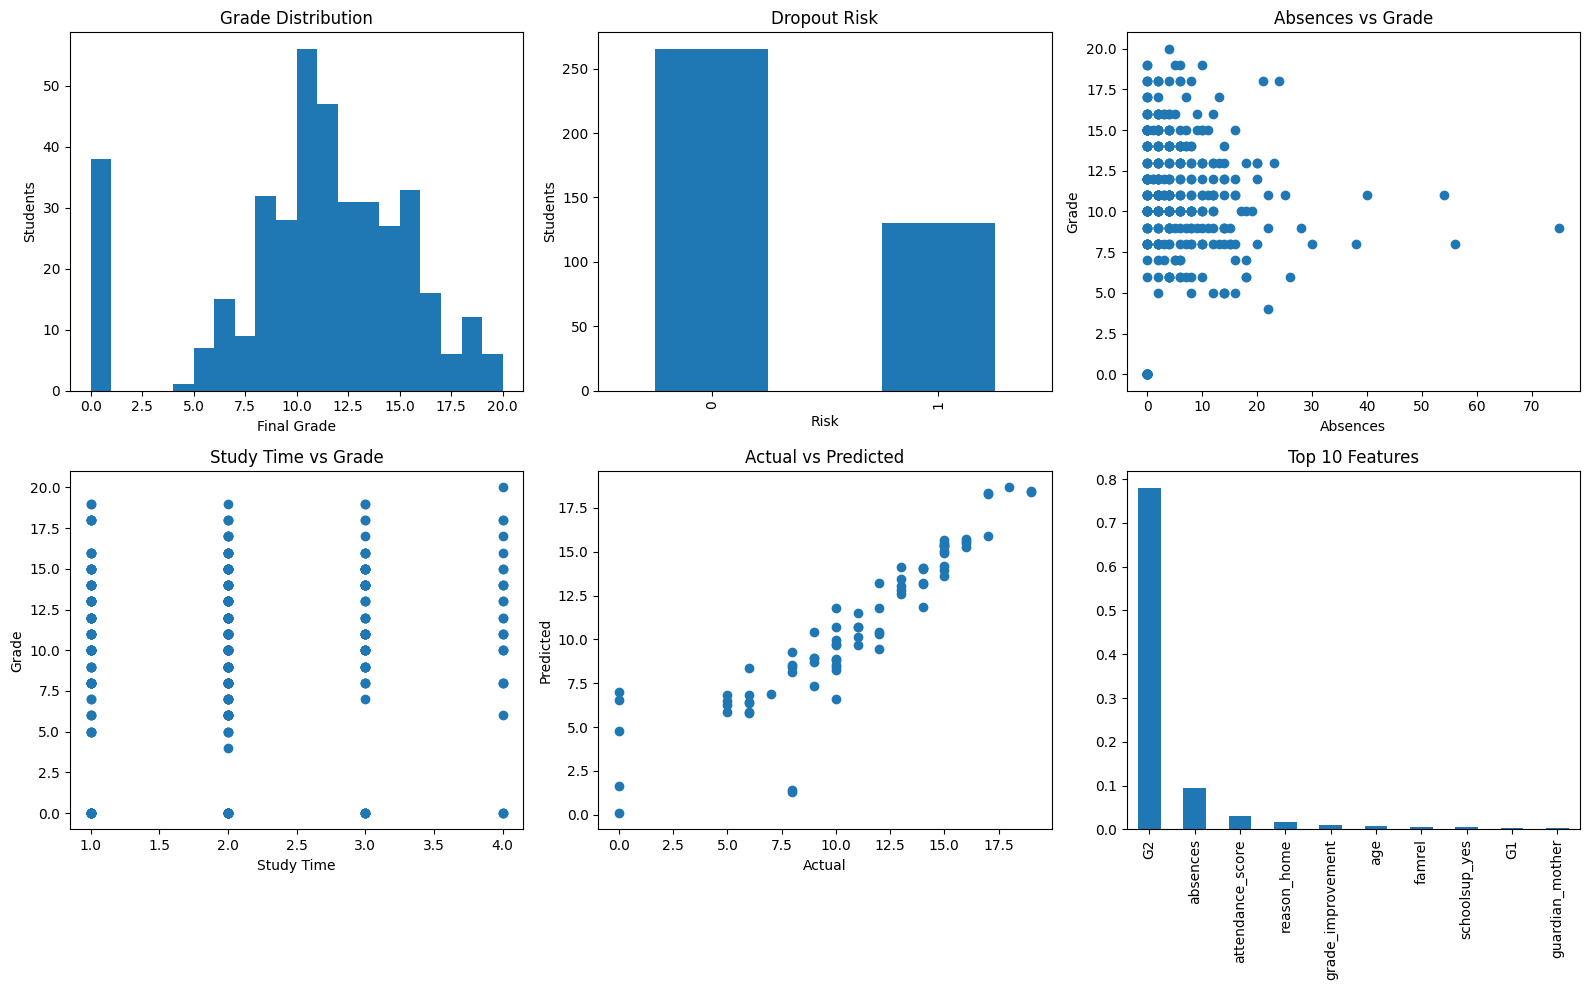

In [14]:
# ==========================================
# DASHBOARD STYLE VISUALIZATION
# ==========================================

fig = plt.figure(figsize=(16, 10))

# -------------------------------
# 1. Grade Distribution
# -------------------------------
plt.subplot(2, 3, 1)
plt.hist(df['G3'], bins=20)
plt.title("Grade Distribution")
plt.xlabel("Final Grade")
plt.ylabel("Students")


# -------------------------------
# 2. Dropout Risk Distribution
# -------------------------------
plt.subplot(2, 3, 2)
df['dropout_risk'].value_counts().plot(kind='bar')
plt.title("Dropout Risk")
plt.xlabel("Risk")
plt.ylabel("Students")


# -------------------------------
# 3. Absences vs Grade
# -------------------------------
plt.subplot(2, 3, 3)
plt.scatter(df['absences'], df['G3'])
plt.title("Absences vs Grade")
plt.xlabel("Absences")
plt.ylabel("Grade")


# -------------------------------
# 4. Study Time vs Grade
# -------------------------------
plt.subplot(2, 3, 4)
plt.scatter(df['studytime'], df['G3'])
plt.title("Study Time vs Grade")
plt.xlabel("Study Time")
plt.ylabel("Grade")


# -------------------------------
# 5. Actual vs Predicted Grades
# -------------------------------
plt.subplot(2, 3, 5)
plt.scatter(yg_test, grade_preds)
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")


# -------------------------------
# 6. Feature Importance (Top 10)
# -------------------------------
plt.subplot(2, 3, 6)

feat_imp = pd.Series(grade_model.feature_importances_, index=X_grade.columns)
top_feat = feat_imp.sort_values(ascending=False)[:10]

top_feat.plot(kind='bar')
plt.title("Top 10 Features")

plt.tight_layout()
plt.show()


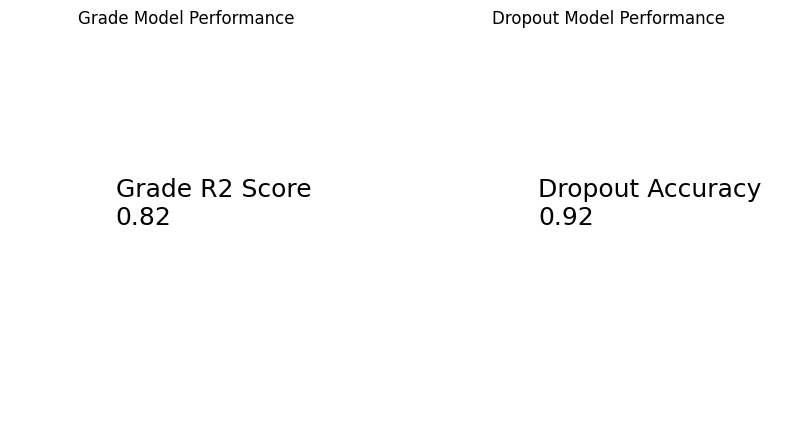

In [15]:
# ==========================================
# KPI DASHBOARD (Metrics Summary)
# ==========================================

fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.text(0.3,0.5, f"Grade R2 Score\n{r2:.2f}", fontsize=18)
plt.axis('off')
plt.title("Grade Model Performance")

plt.subplot(1,2,2)
plt.text(0.3,0.5, f"Dropout Accuracy\n{acc:.2f}", fontsize=18)
plt.axis('off')
plt.title("Dropout Model Performance")

plt.show()
